In [2]:
import numpy as np
import cupy as cp
import ray
import astropy.units as u
from astropy.io import fits
from IPython.display import clear_output
import time
from pathlib import Path
from matplotlib.patches import Circle

import poppy

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

from importlib import reload
import copy

import roman_phasec_proper as phasec
dm_dir = phasec.lib_dir + '/examples/'

import misc

from poppy_roman_cgi_phasec import cgi

# optics = ['pupil', 'primary', 'secondary', 'poma_fold', 'm3', 'm4', 'm5', 'tt_fold', 'fsm', 'oap1', 
#           'focm', 'oap2', 'dm1', 'dm2', 'oap3', 'fold3', 'oap4', 'pupilmask', 'oap5', 'fpm', 'oap6',
#           'lyotstop', 'oap7', 'fieldstop', 'oap8', 'filter', 
#           'imaging_lens_lens1', 'imaging_lens_lens2', 'fold4', 'image']

def save_wf(wavefront, fname):
    wf_int = wavefront.intensity.get()
    wf_phase = wavefront.phase.get()
    wf_sampling = wavefront.pixelscale.value
    
    wf = np.zeros(shape=(2, wf_int.shape[0], wf_int.shape[0]))
    wf[0,:,:] = wf_int
    wf[1,:,:] = wf_phase
    hdr = fits.Header()
    hdr['PIXELSCL'] = wf_sampling
    wf_hdu = fits.PrimaryHDU(wf, header=hdr)
    
    wf_fpath = wf_dir/(fname + '_poppy' + '.fits')
    wf_hdu.writeto(wf_fpath, overwrite=True)
    print( 'Wavefront saved to: '+str(wf_fpath) ) 

# HLC

(268, 268)


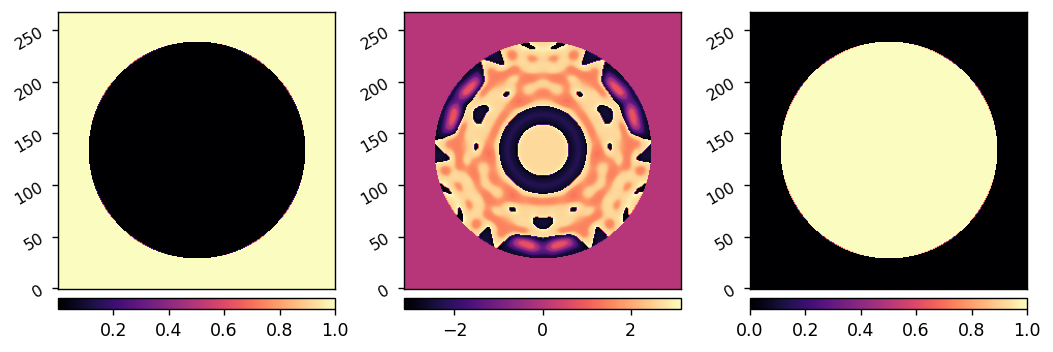

Propagating wavelength 575.000 nm.
PSF calculated in 1.013s


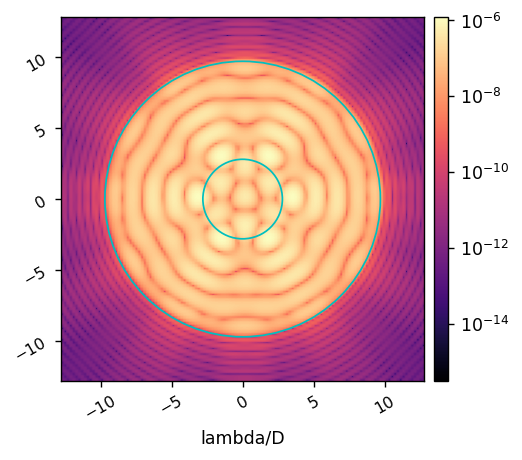

Wavefront saved to: /groups/douglase/kians-data-files/roman-cgi-wfs/hlc/pupil_poppy.fits
Wavefront saved to: /groups/douglase/kians-data-files/roman-cgi-wfs/hlc/primary_poppy.fits
Wavefront saved to: /groups/douglase/kians-data-files/roman-cgi-wfs/hlc/secondary_poppy.fits
Wavefront saved to: /groups/douglase/kians-data-files/roman-cgi-wfs/hlc/poma_fold_poppy.fits
Wavefront saved to: /groups/douglase/kians-data-files/roman-cgi-wfs/hlc/m3_poppy.fits
Wavefront saved to: /groups/douglase/kians-data-files/roman-cgi-wfs/hlc/m4_poppy.fits
Wavefront saved to: /groups/douglase/kians-data-files/roman-cgi-wfs/hlc/m5_poppy.fits
Wavefront saved to: /groups/douglase/kians-data-files/roman-cgi-wfs/hlc/tt_fold_poppy.fits
Wavefront saved to: /groups/douglase/kians-data-files/roman-cgi-wfs/hlc/fsm_poppy.fits
Wavefront saved to: /groups/douglase/kians-data-files/roman-cgi-wfs/hlc/oap1_poppy.fits
Wavefront saved to: /groups/douglase/kians-data-files/roman-cgi-wfs/hlc/focm_poppy.fits
Wavefront saved to: /g

In [3]:
poppy_log.disabled = True

reload(cgi)
hlc = cgi.CGI(cgi_mode='hlc', npsf=128, psf_pixelscale_lamD=0.2, 
              use_fpm=True,
              use_pupil_defocus=False, 
#               use_opds=True,
             )

iwa = 2.8
owa = 9.7

misc.myimshow3(np.abs(hlc.fpm_phasor)**2, np.angle(hlc.fpm_phasor), hlc.fpm_mask)

wfs = hlc.calc_wfs()

psf_mono = wfs[-1].intensity

patches = [Circle((0, 0), iwa, color='c', fill=False), Circle((0, 0), owa, color='c', fill=False)]
misc.myimshow(psf_mono, lognorm=True, pxscl=hlc.psf_pixelscale_lamD, patches=patches,
#               npix=80,
             )

wf_dir = Path('/groups/douglase/kians-data-files/roman-cgi-wfs/hlc')
for i,wf in enumerate(wfs):
    save_wf(wf, hlc.optics[i])

In [4]:
settings = hlc.copy_mode_settings()
settings

[{'cgi_mode': 'hlc',
  'wavelength': <Quantity 5.75e-07 m>,
  'npsf': 128,
  'psf_pixelscale': <Quantity 5.98e-06 m / pix>,
  'interp_order': 3,
  'offset': (0, 0),
  'use_fpm': True,
  'use_fieldstop': True,
  'use_pupil_defocus': False,
  'use_opds': False,
  'dm1_ref': array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]),
  'dm2_ref': array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]),
  'polaxis': 0}]

In [9]:
!nvidia-smi

Thu Jun 30 03:28:01 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100S-PCI...  On   | 00000000:25:00.0 Off |                    0 |
| N/A   34C    P0    38W / 250W |   3573MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [13]:
from poppy_roman_cgi_phasec import hlc_ray

reload(hlc_ray)

for i in range(3):
    future_psfs = hlc_ray.run.options(num_cpus=10, num_gpus=1/3).remote(**settings[0], return_intermediates=False)

psfs = ray.get(future_psfs)
# psf_mono = psf.intensity

# patches = [Circle((0, 0), iwa, color='c', fill=False), Circle((0, 0), owa, color='c', fill=False)]
# misc.myimshow(psf_mono, lognorm=True, pxscl=hlc.psf_pixelscale_lamD, patches=patches,
# #               npix=80,
#              )

(run pid=12452) (268, 268)
(run pid=12462) (268, 268)
(run pid=12465) (268, 268)


In [14]:
psfs

(268, 268)


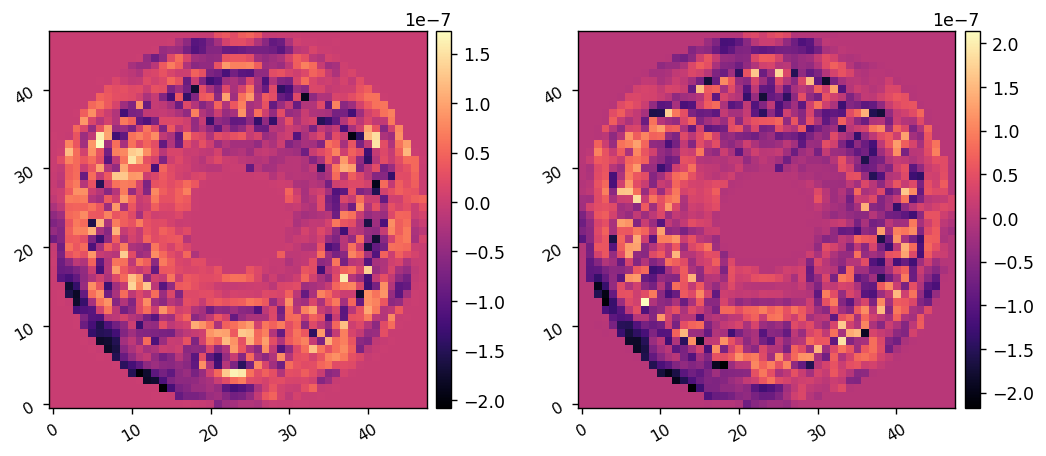

Propagating wavelength 575.000 nm.
PSF calculated in 0.351s


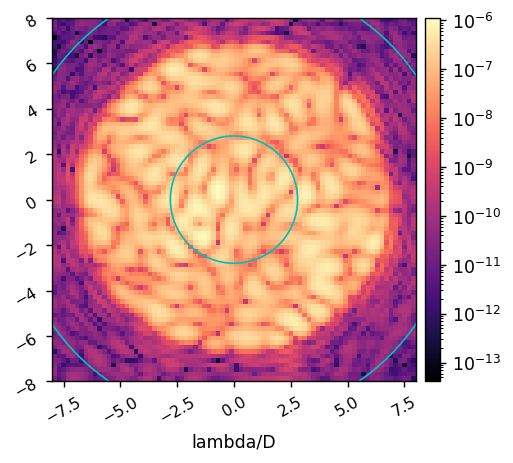

In [16]:
reload(cgi)
hlc = cgi.CGI(cgi_mode='hlc', npsf=128, psf_pixelscale_lamD=0.2, 
              use_fpm=True, 
              use_pupil_defocus=True, use_opds=True,)

iwa = 2.8
owa = 9.7

dm1_fpath = dm_dir + 'hlc_best_contrast_dm1.fits'
dm2_fpath = dm_dir + 'hlc_best_contrast_dm2.fits'

dm1_cmd = 2*fits.getdata(dm1_fpath)
dm2_cmd = 2*fits.getdata(dm2_fpath)

misc.myimshow2(dm1_cmd, dm2_cmd)

hlc.set_dm1(dm1_cmd)
hlc.set_dm2(dm2_cmd)

psf = hlc.calc_psf()

psf_mono = psf.intensity

patches = [Circle((0, 0), iwa, color='c', fill=False), Circle((0, 0), owa, color='c', fill=False)]
misc.myimshow(psf_mono, lognorm=True, npix=80, pxscl=hlc.psf_pixelscale_lamD, patches=patches)

# wf_dir = Path('/groups/douglase/kians-data-files/roman-cgi-wfs/hlc')
# for i,wf in enumerate(wfs):
#     save_wf(wf, optics[i])

# SPC-Wide

Propagating wavelength 825.000 nm.
PSF calculated in 0.344s


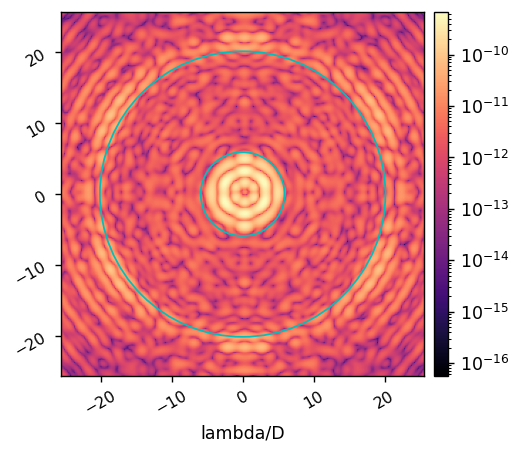

Wavefront saved to: /groups/douglase/kians-data-files/roman-cgi-wfs/spc-wide/pupil_poppy.fits
Wavefront saved to: /groups/douglase/kians-data-files/roman-cgi-wfs/spc-wide/primary_poppy.fits
Wavefront saved to: /groups/douglase/kians-data-files/roman-cgi-wfs/spc-wide/secondary_poppy.fits
Wavefront saved to: /groups/douglase/kians-data-files/roman-cgi-wfs/spc-wide/poma_fold_poppy.fits
Wavefront saved to: /groups/douglase/kians-data-files/roman-cgi-wfs/spc-wide/m3_poppy.fits
Wavefront saved to: /groups/douglase/kians-data-files/roman-cgi-wfs/spc-wide/m4_poppy.fits
Wavefront saved to: /groups/douglase/kians-data-files/roman-cgi-wfs/spc-wide/m5_poppy.fits
Wavefront saved to: /groups/douglase/kians-data-files/roman-cgi-wfs/spc-wide/tt_fold_poppy.fits
Wavefront saved to: /groups/douglase/kians-data-files/roman-cgi-wfs/spc-wide/fsm_poppy.fits
Wavefront saved to: /groups/douglase/kians-data-files/roman-cgi-wfs/spc-wide/oap1_poppy.fits
Wavefront saved to: /groups/douglase/kians-data-files/roman-

In [3]:
poppy_log.disabled = True

reload(cgi)
spcw = cgi.CGI(cgi_mode='spc-wide', npsf=256, psf_pixelscale_lamD=0.2, 
               use_fpm=True,
               use_pupil_defocus=False, 
               return_intermediates=True)
iwa = 5.9
owa = 20.1

wfs = spcw.calc_psf()

psf_mono = wfs[-1].intensity

patches = [Circle((0, 0), iwa, color='c', fill=False), Circle((0, 0), owa, color='c', fill=False)]
misc.myimshow(psf_mono, lognorm=True, pxscl=spcw.psf_pixelscale_lamD, patches=patches)

wf_dir = Path('/groups/douglase/kians-data-files/roman-cgi-wfs/spc-wide')
for i,wf in enumerate(wfs):
    save_wf(wf, optics[i])

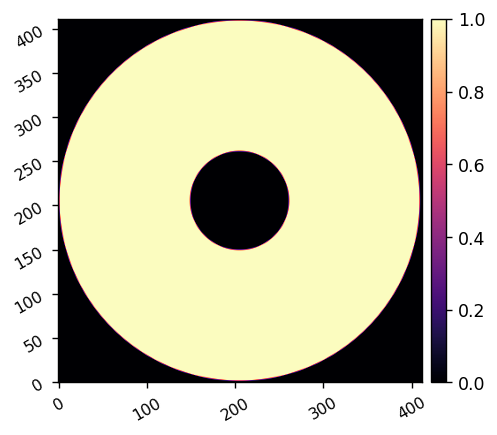

In [49]:
misc.myimshow(spcw.FPM.amplitude)